## Writeup and Code

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [260]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell(shown below): 

In [10]:
# 1. read car images and non-car images
car_images = glob.glob('./train_dataset/vehicles/vehicles/**/*.png')
noncar_images = glob.glob('./train_dataset/non-vehicles/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:


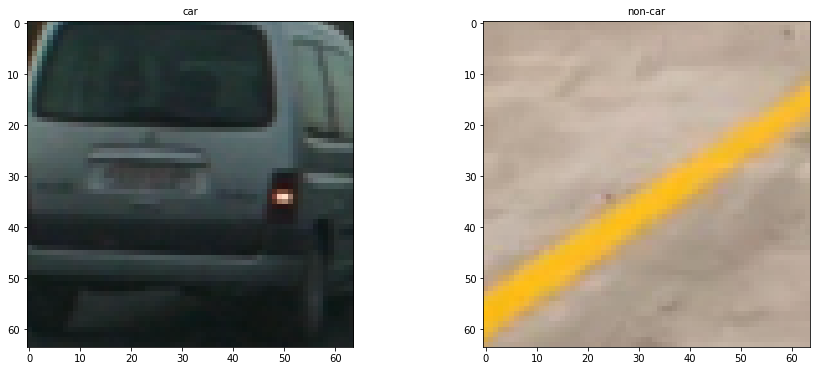

In [11]:
# 2. visualize the examples of the data
fig,axs = plt.subplots(1, 2, figsize=(15,6))
axs = axs.ravel()

index_car = np.random.randint(0,len(car_images))
index_noncar = np.random.randint(0,len(noncar_images))
image_car = cv2.imread(car_images[index_car])
image_car = cv2.cvtColor(image_car, cv2.COLOR_BGR2RGB)
image_noncar = cv2.imread(noncar_images[index_noncar])
image_noncar = cv2.cvtColor(image_noncar, cv2.COLOR_BGR2RGB)

axs[0].set_title('car', fontsize=10)
axs[0].imshow(image_car)
axs[1].set_title('non-car', fontsize=10)
axs[1].imshow(image_noncar)

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Here is an example using the `B-channel` color space and HOG parameters of `orientations=11`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

/home/lars/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


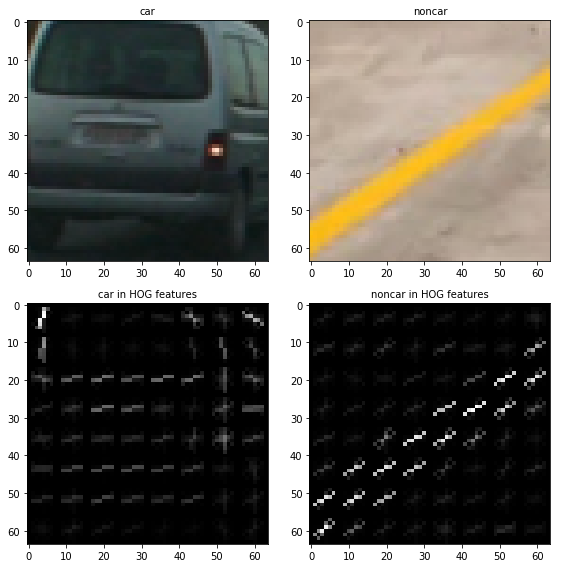

In [128]:
orient = 11
pix_per_cell = 8
cell_per_block = 2

hog_car_features, hog_car_image = get_hog_features(image_car[:,:,2], orient, 
                                                   pix_per_cell, cell_per_block, 
                                                   vis=True, feature_vec=True)
hog_noncar_features, hog_noncar_image = get_hog_features(image_noncar[:,:,2], orient, 
                                                   pix_per_cell, cell_per_block, 
                                                   vis=True, feature_vec=True)

fig,axs = plt.subplots(2, 2, figsize=(8,8))
axs = axs.ravel()
fig.tight_layout()

axs[0].set_title('car', fontsize=10)
axs[0].imshow(image_car)
axs[1].set_title('noncar', fontsize=10)
axs[1].imshow(image_noncar)
axs[2].set_title('car in HOG features', fontsize=10)
axs[2].imshow(hog_car_image, cmap='gray')
axs[3].set_title('noncar in HOG features', fontsize=10)
axs[3].imshow(hog_noncar_image, cmap='gray')

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and based on the accuracy and training time for linear SVM classifier, I decide to convert my image into 'YUV' and then use `orientations=11`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` as my HOG parameters, the code of this part is a function called "extract_features", which is used for HOG features extraction for training set.

In [263]:
# HOG features extraction for training set
def extract_features(imgs, cspace='RGB', orient=11, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#### 3. Describe how you trained a classifier using your selected HOG features.

I trained a linear SVM using `sklearn.svm.LinearSVC()` to train a SVM classifier to decide each window is a "cars" or "non-cars" class. Before training, I used the same feature extraction function and split the train and test set into 9:1 and get the accuracy of SVM classifier

In [264]:
colorspace = 'YUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

71.15 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468
6.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  0.]
0.00138 Seconds to predict 10 labels with SVC


### Sliding Window Search

#### 1. Describe how you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions using multiple scales in different areas all over the image. Due to extract HOG features is a time-consuming process, I decide to extract HOG features just once for the entire region of interest in each full image frame and subsample that array for each sliding window. To do this, a find_cars fucntion is coded below: 

In [265]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
# steps:
# 1. define the span for searching and convert color scale
# 2. resize searching span based on the scale
# 3. define blocks and steps
    boxes = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion
    if colorspace != 'RGB':
        if colorspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif colorspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif colorspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif colorspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif colorspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1,-1)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)           
    return boxes

The find_cars will return all the positive boxes. Therefore, a draw_boxes function is shown as below to draw all positive boxes on the frame of image. 

In [420]:
# applied different bbox on the different area
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random':
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YUV 3-channel HOG features in the feature vector, which provided a nice result.  Here are some example images:

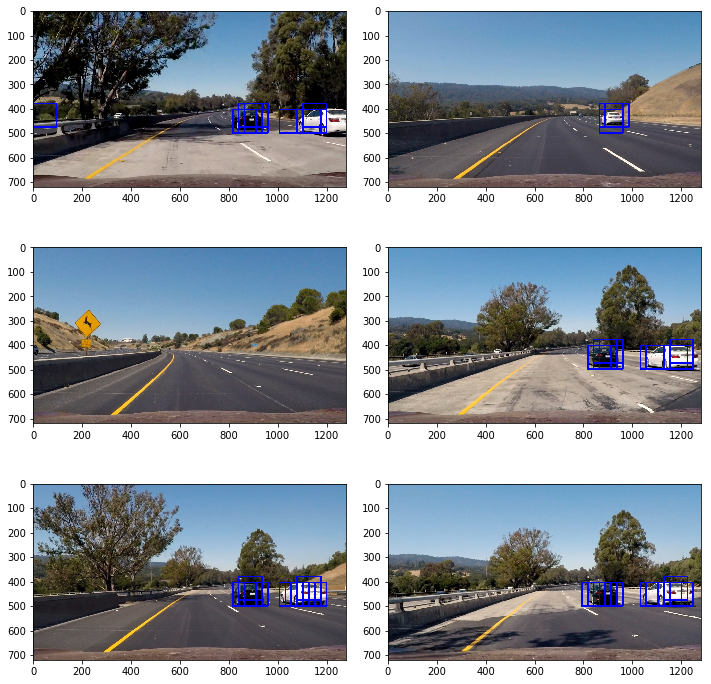

In [421]:
ystart = 380
ystop = 525
scale = 1.5
orient = 11
pix_per_cell = 8
cell_per_block = 2

fig, axs = plt.subplots(3, 2, figsize=(10,10))
axs = axs.ravel()
fig.tight_layout()
test_images = glob.glob('./test_images/test*.jpg')
imgs = []

for fname in images:
    img = mpimg.imread(fname)
    imgs.append(img)

for i in range(len(imgs)):
    boxes = find_cars(imgs[i], ystart, ystop, colorspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    out_img = draw_boxes(imgs[i], boxes)
    axs[i].imshow(out_img)

#### 3. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.
I add a heat-map from these detections in order to combine overlapping detections and remove false positives, the step-by-step demonstration is shown as below:
1. define heat-map function by add heat for all pixels within positive box

In [392]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

The result is shown as below

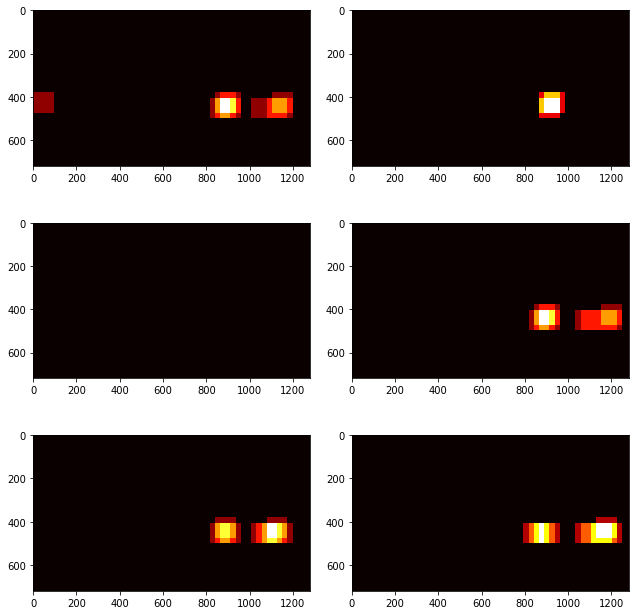

In [422]:
fig, axs = plt.subplots(3, 2, figsize = (9,9))
axs = axs.ravel()
fig.tight_layout()

for i in range(len(imgs)):
    heatmap_img = np.zeros_like(imgs[i][:,:,0])
    boxes = find_cars(imgs[i], ystart, ystop, colorspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    heatmap_img = add_heat(heatmap_img, boxes)
    axs[i].imshow(heatmap_img, cmap='hot')

2. define a threshold to reject areas affected by false positives.

In [394]:
def threshold(heatmap, threshold=1):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

The result is shown as below

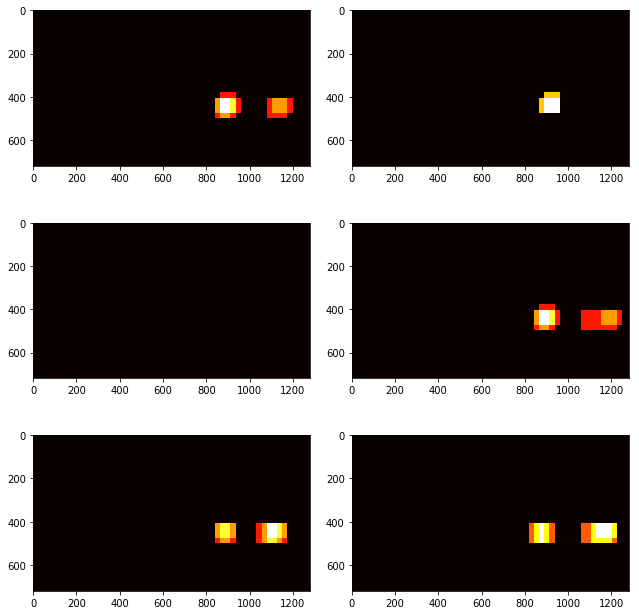

In [423]:
fig, axs = plt.subplots(3, 2, figsize = (9,9))
axs = axs.ravel()
fig.tight_layout()

for i in range(len(imgs)):
    heatmap_img = np.zeros_like(imgs[i][:,:,0])
    boxes = find_cars(imgs[i], ystart, ystop, colorspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    heatmap = add_heat(heatmap_img, boxes)
    heatmap_thresh = threshold(heatmap, 1)
    axs[i].imshow(heatmap_thresh, cmap='hot')

3. Using the label() function from scipy.ndimage.measurements to shown how many cars in each frame

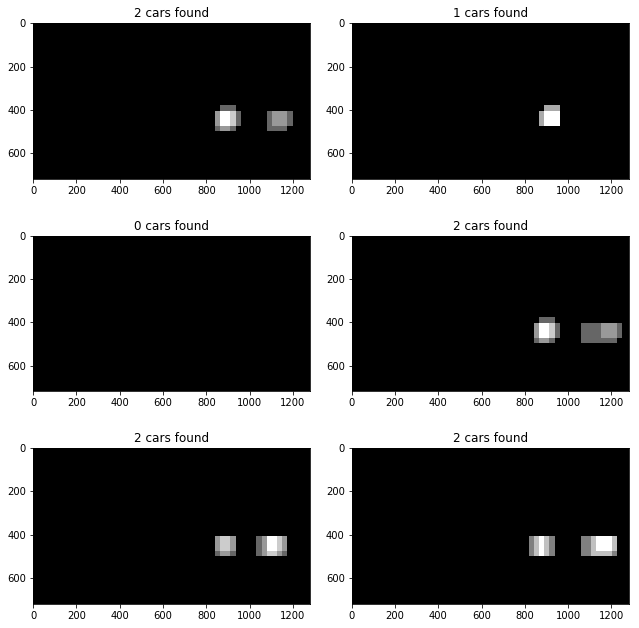

In [424]:
fig, axs = plt.subplots(3, 2, figsize = (9,9))
axs = axs.ravel()
fig.tight_layout()

for i in range(len(imgs)):
    heatmap_img = np.zeros_like(imgs[i][:,:,0])
    boxes = find_cars(imgs[i], ystart, ystop, colorspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    heatmap = add_heat(heatmap_img, boxes)
    heatmap_thresh = threshold(heatmap, 1)
    labels = label(heatmap_thresh)
    axs[i].set_title(str(labels[1])+' cars found')
    axs[i].imshow(heatmap_thresh, cmap='gray')

4. Take the labels box position and define a new draw_labeled_bboxes function to draw filtered box on the original image frame

...


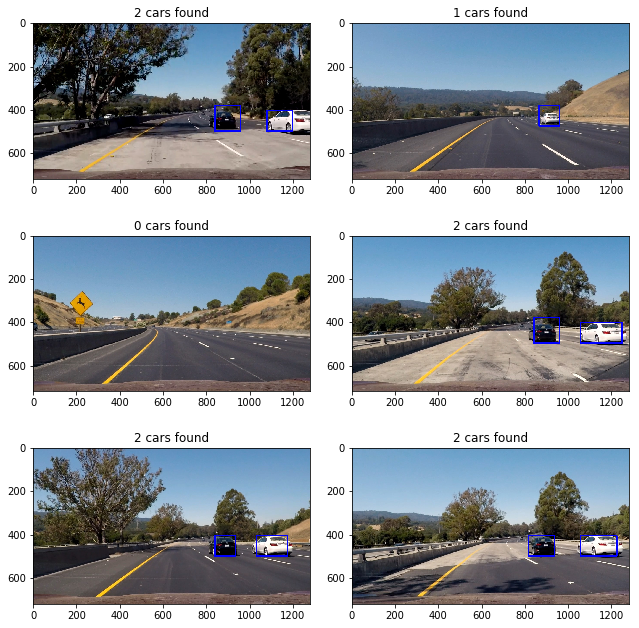

In [425]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, boxes
# Draw bounding boxes on a copy of the image
fig, axs = plt.subplots(3, 2, figsize = (9,9))
axs = axs.ravel()
fig.tight_layout()

for i in range(len(imgs)):
    heatmap_img = np.zeros_like(imgs[i][:,:,0])
    boxes = find_cars(imgs[i], ystart, ystop, colorspace, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    heatmap = add_heat(heatmap_img, boxes)
    heatmap_thresh = threshold(heatmap, 1)
    labels = label(heatmap_thresh)
    draw_img, boxes = draw_labeled_bboxes(np.copy(imgs[i]), labels)
    axs[i].set_title(str(labels[1])+' cars found')
    axs[i].imshow(draw_img)
print('...')

### Apply multiple scales on different area of image to improve accuracy

In [426]:
def process_frame(img):

    boxes = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2

    ystart = 350
    ystop = 500
    scale = 1.0
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    
    ystart = 380
    ystop = 525
    scale = 1.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 410
    ystop = 530
    scale = 1.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 358
    ystop = 550
    scale = 2.0
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 386
    ystop = 585
    scale = 2.0
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
   
    ystart = 400
    ystop = 586
    scale = 3
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 700
    scale = 3.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    
    boxes = [item for sublist in boxes for item in sublist] 
   
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap_img, boxes)
    heatmap_thresh = threshold(heatmap, 4)
    labels = label(heatmap_thresh)
    draw_img, boxes = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

### Here the resulting bounding boxes are drawn onto the test images

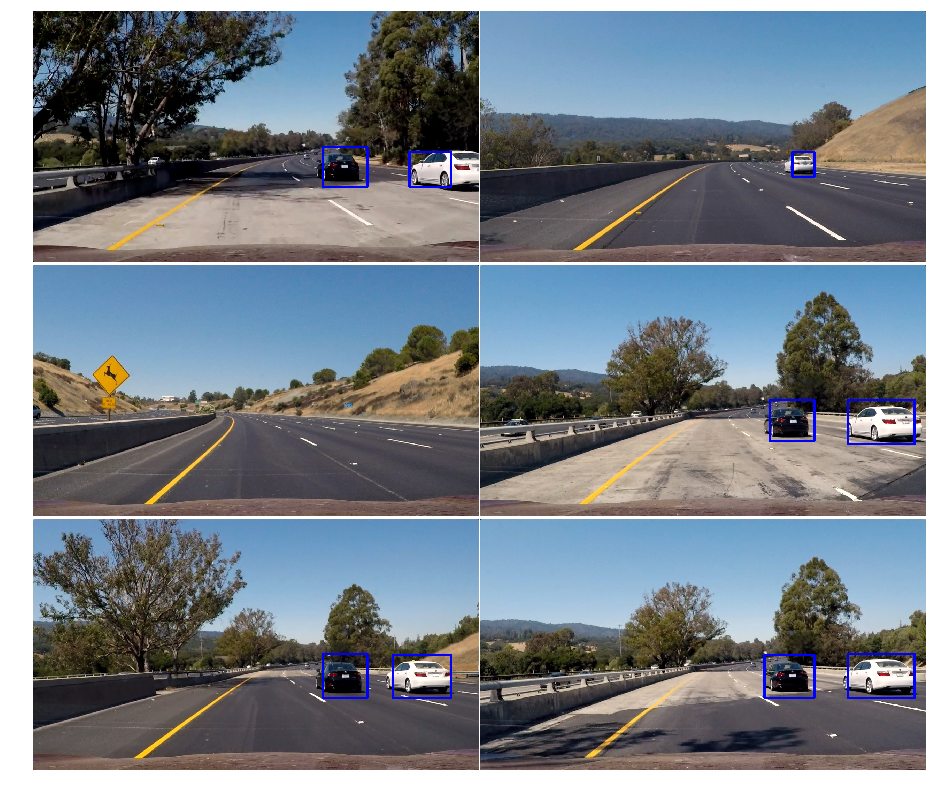

In [427]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Define a class to store previous boxes for video frame
With store certain numbers of previous boxes, vehicle detection will get smoother.

In [428]:
class Detect_boxes():
    def __init__(self):
        # history of rectangles previous n frames
        self.previous_boxes = [] 
        
    def add_previous(self, boxes, nmax):
        self.previous_boxes.append(boxes)
        if len(self.previous_boxes) > nmax:
            # throw out oldest boxes
            self.previous_boxes = self.previous_boxes[len(self.previous_boxes)-nmax:]

Add previous boxes when detect cars in video frame, the process_frame_video is the function to realize this.

In [417]:
def process_frame_video(img):

    boxes = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2

    ystart = 350
    ystop = 500
    scale = 1.0
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    
    ystart = 380
    ystop = 525
    scale = 1.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 410
    ystop = 530
    scale = 1.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 400
    ystop = 530
    scale = 2.0
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 432
    ystop = 560
    scale = 2.0
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
   
    ystart = 400
    ystop = 610
    scale = 3.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    ystart = 420
    ystop = 690
    scale = 3.5
    boxes.append(find_cars(img, ystart, ystop, colorspace, scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block))
    
    boxes = [item for sublist in boxes for item in sublist] 
    
    if len(boxes) > 0:
        bboxes.add_previous(boxes, 15)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    for box in bboxes.previous_boxes:
        heatmap_img = add_heat(heatmap_img, box)
    heatmap_thresh = threshold(heatmap_img, 2 + len(bboxes.previous_boxes)//2)
    
    labels = label(heatmap_thresh)
    draw_img, boxes = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

### Video implementation
The test video and project video is in the folder 'project5'

In [352]:
bboxes = Detect_boxes()

test_out_file2 = 'test_video_out1.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out1.mp4
[MoviePy] Writing video test_video_out1.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out1.mp4 

CPU times: user 47.6 s, sys: 104 ms, total: 47.7 s
Wall time: 18 s


In [418]:
bboxes = Detect_boxes()

test_out_file2 = 'video_out1.mp4'
clip_test2 = VideoFileClip('project_video_output.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video video_out1.mp4
[MoviePy] Writing video video_out1.mp4


100%|█████████▉| 1260/1261 [10:06<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out1.mp4 

CPU times: user 27min 30s, sys: 3.53 s, total: 27min 34s
Wall time: 10min 6s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?
 
Problems/issues: 
1. Take a long time to experiment different scales on different start and stop region, but the result of that is still not so good because it's take time to detect the car when car just appear.
2. When two cars overlap, my pipeline will detect two cars as one car, right now, I don't have a idea to figure that out.
3. Still could detect false objects, the accuracy of classifier need improve.

Likely to fail? 
1. Because I add the store class for previous boxes. When detect the vehicles coming from opposite direction, this will have a lag to stop detecting because car from opposite direction only take a very short time but the detection is quite clear.It's kind of a trade off to improve accuracy and smoothness. 
2. When drive to shadows, it's likely to fail.
3. when other cars is so close to you, maybe just half car shown in the frame,it's likely to fail.

More robust? 
1. I think maybe just HOG features are not enough, I could add color histogram to improve the accuracy of SVM classifier or just use another classifier such as nerual network to further improve the accuracy of detection. 
2. Maybe add more scales in improve the searching or develop a linear funciton to generate much more scales based on the y-pixel of image. 